
Todo:
- ~Pivot the data tables to these cols, startCP, endCP, distance, height gain, timetaken (based on variable)~
- ~Find every permutation of checkpoint routes (starting and ending with 0 & 99)~
- For every permutation, find the time of arrival at each cp, compare to open & closes
- discount non-viable routes
- select best route on finish time
- ~Get the opening times and grid refs for a few previous years
- ~Put the grid refs on the opening times csv as the source for checkpoint names and combinations
- Create Route Logger (logs which routes have been tried)


Functions:
- Conversion of BNG refs to lat/long
- Bing maps calculate_route_api for distance calcs 
- Elevations calculator
- Time Rounder (to allow joins to openings_df)
- Checkpoint Visitor (adds to visited_checkpoints variable, and subtracts from unvisited checkpoints variable)




In [0]:
from pyspark.sql.functions import col, expr, first
from pyspark.sql import functions as F, DataFrame, Window
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, FloatType, ArrayType, TimestampType
from datetime import datetime, time, timedelta
import requests 
import json
import itertools
from functools import reduce
import numpy as np


In [0]:
dbutils.widgets.dropdown("Competition_Year", "2024", ["2025", "2024", "2019", "2018", "2017"])
Competition_Year = dbutils.widgets.get("Competition_Year")

dbutils.widgets.text("Dwell", "7")
StopTimeAtCheckPoints = dbutils.widgets.get("Dwell")

dbutils.widgets.text("Speed", "5.30")
Speed = dbutils.widgets.get("Speed")

dbutils.widgets.text("StartTime", "10:00:00")
StartTime =  datetime.strptime( dbutils.widgets.get("StartTime"), '%H:%M:%S')
FinishTime = StartTime + timedelta(hours=7)

dbutils.widgets.text("Naismith", "10")
AddMinutesPer10mHeight = dbutils.widgets.get("Naismith")

viable_routes = []

In [0]:
databricksServicePrincipalClientId = dbutils.secrets.get(scope = "allpay-dwh01-scope", key = "Databricks-Client-Id")
databricksServicePrincipalClientSecret = dbutils.secrets.get(scope = "allpay-dwh01-scope", key = "Databricks-Client-Secret")
azureADTenant = dbutils.secrets.get(scope = "allpay-dwh01-scope", key = "AzureAD-Tenant-GUID")
endpoint = "https://login.microsoftonline.com/" + azureADTenant + "/oauth2/token"
Folder = "abfss://qaha7ai04@allpaydwh01datalake.dfs.core.windows.net"
spark.conf.set("fs.azure.account.auth.type", "OAuth")
spark.conf.set("fs.azure.account.oauth.provider.type", "org.apache.hadoop.fs.azurebfs.oauth2.ClientCredsTokenProvider")
spark.conf.set("fs.azure.account.oauth2.client.id", databricksServicePrincipalClientId)
spark.conf.set("fs.azure.account.oauth2.client.secret", databricksServicePrincipalClientSecret)
spark.conf.set("fs.azure.account.oauth2.client.endpoint", endpoint)

In [0]:
distances_file_path = Folder + "/Dovetrek/Distances.csv"
opening_file_path = Folder + "/Dovetrek/Openings_" + Competition_Year + ".csv"
heights_file_path = Folder + "/Dovetrek/Heights.csv"

# Read csv files into PySpark DataFrames
distances_df = spark.read.csv(distances_file_path, header=True, inferSchema=True)
openings_df = spark.read.csv(opening_file_path, header=True, inferSchema=True)
heights_df = spark.read.csv(heights_file_path, header=True, inferSchema=True)

In [0]:
openings_df = openings_df.withColumn("NGR_Easting", F.concat(F.lit("4"), F.substring(openings_df.BNG, 1, 3), F.lit("00"))) \
                    .withColumn("NGR_Northing", F.concat(F.lit("3"), F.substring(openings_df.BNG, 5, 3), F.lit("00")))
openings_df.show()

+------+-------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-----------+------------+
|    CP|    BNG|1000|1030|1100|1130|1200|1230|1300|1330|1400|1430|1500|1530|1600|1630|1700|NGR_Easting|NGR_Northing|
+------+-------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-----------+------------+
| Start|202 859|   1|   1|   1|   1|   1|   1|   1|   1|   1|   1|   1|   1|   1|   1|   1|     420200|      385900|
|   CP1|198 849|   0|   0|   0|   1|   1|   1|   1|   1|   1|   1|   1|   1|   0|   0|   0|     419800|      384900|
|   CP2|186 850|   0|   1|   1|   1|   0|   0|   0|   0|   1|   1|   1|   1|   0|   0|   0|     418600|      385000|
|   CP3|159 876|   1|   1|   1|   1|   0|   0|   0|   1|   1|   1|   1|   0|   0|   0|   0|     415900|      387600|
|   CP4|125 834|   0|   0|   0|   1|   1|   1|   0|   0|   1|   1|   1|   0|   0|   0|   0|     412500|      383400|
|   CP8|195 860|   0|   1|   1|   1|   0|   0|   0|   0|   0|   

In [0]:
LatLong_Df = spark.createDataFrame([(1,1.0,1.0)], schema = 'CP string, Latitude float, Longitude float')
LatLong_Df = LatLong_Df.filter('1!=1')


# Convert DataFrame to a list
gridrefs_list = openings_df.select(openings_df.CP, openings_df.NGR_Easting, openings_df.NGR_Northing).collect()

# Iterate over the list
for row in gridrefs_list:
    # Perform desired operations with the column values
    resp = requests.get("http://webapps.bgs.ac.uk/data/webservices/CoordConvert_LL_BNG.cfc?method=BNGtoLatLng&easting=" + row.NGR_Easting + "&northing=" + row.NGR_Northing)
    
    # Parse the JSON response
    json_resp = json.loads(resp.text)

    # Extract latitude and longitude values
    latitude = json_resp['LATITUDE']
    longitude = json_resp['LONGITUDE']
    cp = row["CP"]
    
    df = spark.createDataFrame([(cp, latitude, longitude)], 'CP string, Latitude float, Longitude float')
    #df.show()
    LatLong_Df = LatLong_Df.union(df)

LatLong_Df.show()

+------+---------+----------+
|    CP| Latitude| Longitude|
+------+---------+----------+
| Start|53.369583|-1.6978767|
|   CP1|53.360607|-1.7039505|
|   CP2| 53.36155|-1.7219754|
|   CP3| 53.38501| -1.762416|
|   CP4|53.347347|-1.8136975|
|   CP8|53.370506|-1.7083907|
|   CP9| 53.34539|-1.7310928|
|  CP10|53.357117|-1.7490488|
|  CP11|53.364353|-1.7715472|
|  CP12|53.372417|  -1.75948|
|  CP13| 53.35721|-1.7971274|
|  CP14| 53.34984|-1.7100339|
|  CP15|53.358883|-1.7340131|
|  CP16| 53.35176|-1.7671076|
|  CP17| 53.34709|-1.6905249|
|Finish| 53.35178|-1.7776234|
+------+---------+----------+



In [0]:
openings_df = openings_df.join(LatLong_Df, openings_df.CP == LatLong_Df.CP).drop(LatLong_Df.CP)

LatLong_Df.unpersist()
# Show DataFrame
openings_df.show()

+------+-------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-----------+------------+---------+----------+
|    CP|    BNG|1000|1030|1100|1130|1200|1230|1300|1330|1400|1430|1500|1530|1600|1630|1700|NGR_Easting|NGR_Northing| Latitude| Longitude|
+------+-------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-----------+------------+---------+----------+
| Start|202 859|   1|   1|   1|   1|   1|   1|   1|   1|   1|   1|   1|   1|   1|   1|   1|     420200|      385900|53.369583|-1.6978767|
|   CP1|198 849|   0|   0|   0|   1|   1|   1|   1|   1|   1|   1|   1|   1|   0|   0|   0|     419800|      384900|53.360607|-1.7039505|
|   CP2|186 850|   0|   1|   1|   1|   0|   0|   0|   0|   1|   1|   1|   1|   0|   0|   0|     418600|      385000| 53.36155|-1.7219754|
|   CP3|159 876|   1|   1|   1|   1|   0|   0|   0|   1|   1|   1|   1|   0|   0|   0|   0|     415900|      387600| 53.38501| -1.762416|
|   CP4|125 834|   0|   0|   0|   

In [0]:
StartCPs = openings_df.select("CP").withColumnRenamed("CP","StartCP")
FinishCPs = openings_df.select("CP").withColumnRenamed("CP","FinishCP")
Bing_CP_Combinations_DF = StartCPs.crossJoin(FinishCPs)

StartCPs.unpersist
FinishCPs.unpersist

Bing_CP_Combinations_DF = Bing_CP_Combinations_DF.alias("df").join(openings_df.select("CP", "Latitude", "Longitude").withColumnRenamed('Latitude','StartLatitude').withColumnRenamed('Longitude','StartLongitude'), Bing_CP_Combinations_DF.StartCP == openings_df.CP).drop("CP")

Bing_CP_Combinations_DF = Bing_CP_Combinations_DF.alias("df").join(openings_df.select("CP", "Latitude", "Longitude").withColumnRenamed('Latitude','FinishLatitude').withColumnRenamed('Longitude','FinishLongitude'), Bing_CP_Combinations_DF.FinishCP == openings_df.CP).drop("CP")

Bing_CP_Combinations_DF = Bing_CP_Combinations_DF.filter(Bing_CP_Combinations_DF.StartCP != Bing_CP_Combinations_DF.FinishCP)
Bing_CP_Combinations_DF.show()

+-------+--------+-------------+--------------+--------------+---------------+
|StartCP|FinishCP|StartLatitude|StartLongitude|FinishLatitude|FinishLongitude|
+-------+--------+-------------+--------------+--------------+---------------+
|   CP10|     CP1|    53.357117|    -1.7490488|     53.360607|     -1.7039505|
|   CP11|     CP1|    53.364353|    -1.7715472|     53.360607|     -1.7039505|
|   CP12|     CP1|    53.372417|      -1.75948|     53.360607|     -1.7039505|
|   CP13|     CP1|     53.35721|    -1.7971274|     53.360607|     -1.7039505|
|   CP14|     CP1|     53.34984|    -1.7100339|     53.360607|     -1.7039505|
|   CP15|     CP1|    53.358883|    -1.7340131|     53.360607|     -1.7039505|
|   CP16|     CP1|     53.35176|    -1.7671076|     53.360607|     -1.7039505|
|   CP17|     CP1|     53.34709|    -1.6905249|     53.360607|     -1.7039505|
|    CP2|     CP1|     53.36155|    -1.7219754|     53.360607|     -1.7039505|
|    CP3|     CP1|     53.38501|     -1.762416|     

In [0]:
BingMapsAPIKey = dbutils.secrets.get(scope = "allpay-dwh01-scope", key = "BingMapsAPI-Key")

In [0]:
import requests

# Define your Azure Maps API key
AzureMapsAPIKey = dbutils.secrets.get(scope="allpay-dwh01-scope", key="AzureMapsAPI-Key")


# Define the URL for the Azure Maps Elevation API
url = "https://atlas.microsoft.com/elevation/point/json"

# Define the parameters for the request
params = {
    'api-version': '2024-04-01',
    'points': '53.34539,-1.8136975',
    'subscription-key': AzureMapsAPIKey
}

# Make the request to the Azure Maps Elevation API
response = requests.get(url, params=params)

# Check the response status code
if response.status_code == 200:
    elevation_data = response.json()
    print(elevation_data)
else:
    print(f"Error: {response.status_code}")


Error: 404


In [0]:

Bing_CP_Combinations_List = Bing_CP_Combinations_DF.collect()

Bing_Distances_DF = spark.createDataFrame([(1,1.0,1.0,1)], schema = 'StartCP string, FinishCP string, Distance float, Height_Gain int')
Bing_Distances_DF = Bing_Distances_DF.filter("1!=1")

for row in Bing_CP_Combinations_List:

  wp1 = str(row.StartLatitude) + ',' + str(row.StartLongitude)
  wp2 = str(row.FinishLatitude) + ',' + str(row.FinishLongitude)

  route_url = "http://dev.virtualearth.net/REST/v1/Routes/walking"
  route_params = {
      "wayPoint.1": wp1,
      "waypoint.2": wp2,
      "optimize": "distance",
      "avoid": "ferry",
      "routeAttributes": "routePath,excludeItinerary",
      "distanceUnit": "km",
      "key": BingMapsAPIKey
      }
  route_resp = requests.get(route_url,params=route_params)
  
  route_json_resp = json.loads(route_resp.text)
  travel_distance = route_json_resp['resourceSets'][0]['resources'][0]['travelDistance']
  StartCP = row["StartCP"]
  FinishCP = row["FinishCP"]

  height_points = route_json_resp['resourceSets'][0]['resources'][0]['routePath']['line']['coordinates']
  flattened_height_points = str([coordinate for sublist in height_points for coordinate in sublist])[1:-1]

  elevations_url = "http://dev.virtualearth.net/REST/v1/Elevation/List"
  elevations_params = {
    "points": str(flattened_height_points)[1:-1],
    "heights": "ellipsoid",
    "key": BingMapsAPIKey   
  }
  elevations_resp = requests.get(elevations_url,params=elevations_params)
  elevations_json_resp = json.loads(elevations_resp.text)
  elevations = elevations_json_resp['resourceSets'][0]['resources'][0]['elevations']
  differences = [elevations[i+1] - elevations[i] for i in range(len(elevations)-1)]
  height_gain = sum([diff for diff in differences if diff > 0])

  df = spark.createDataFrame([(StartCP, FinishCP, travel_distance, height_gain)], 'StartCP string, FinishCP string, Distance float, Height_Gain int')
  Bing_Distances_DF = Bing_Distances_DF.union(df)
  
Bing_Distances_DF.show()

+-------+--------+--------+-----------+
|StartCP|FinishCP|Distance|Height_Gain|
+-------+--------+--------+-----------+
|   CP10|     CP1|    3.86|        458|
|   CP11|     CP1|   5.732|        692|
|   CP12|     CP1|   5.053|        452|
|   CP13|     CP1|   7.475|        697|
|   CP14|     CP1|   1.851|        285|
|   CP15|     CP1|   2.312|        448|
|   CP16|     CP1|   5.021|        486|
|   CP17|     CP1|   2.173|        265|
|    CP2|     CP1|   1.511|        448|
|    CP3|     CP1|   5.233|        474|
|    CP4|     CP1|   9.173|        802|
|    CP8|     CP1|   1.249|        294|
|    CP9|     CP1|   3.031|        284|
| Finish|     CP1|   5.936|        498|
|  Start|     CP1|   1.283|        279|
|    CP1|    CP10|    3.86|        458|
|   CP11|    CP10|   1.926|        452|
|   CP12|    CP10|   2.134|        264|
|   CP13|    CP10|   3.672|        470|
|   CP14|    CP10|   3.215|        280|
+-------+--------+--------+-----------+
only showing top 20 rows



In [0]:
Bing_Distances_DF = Bing_Distances_DF.withColumn("TimeInMinutes",(col("Distance")/ Speed)*60 + (col("Height_Gain") / AddMinutesPer10mHeight ) )
Bing_Distances_DF.show()

+-------+--------+--------+-----------+------------------+
|StartCP|FinishCP|Distance|Height_Gain|     TimeInMinutes|
+-------+--------+--------+-----------+------------------+
|   CP10|     CP1|    3.86|        458| 89.49811201995274|
|   CP11|     CP1|   5.732|        692|134.09056461262253|
|   CP12|     CP1|   5.053|        452|102.40377328260891|
|   CP13|     CP1|   7.475|        697|154.32264042980268|
|   CP14|     CP1|   1.851|        285| 49.45471643052011|
|   CP15|     CP1|   2.312|        448| 70.97358531592027|
|   CP16|     CP1|   5.021|        486|105.44150839751622|
|   CP17|     CP1|   2.173|        265|51.100001101223924|
|    CP2|     CP1|   1.511|        448|61.905660798414694|
|    CP3|     CP1|   5.233|        474|106.64150718832916|
|    CP4|     CP1|   9.173|        802|184.04528681917012|
|    CP8|     CP1|   1.249|        294| 43.53962211249009|
|    CP9|     CP1|   3.031|        284| 62.71320640276063|
| Finish|     CP1|   5.936|        498|116.9999985317014

In [0]:
distances_df = distances_df.select("_c0","0","1","2","3","4","8","9","10","11","12","13","14","15","16","17","99")
distances_df = distances_df.filter(col("_c0").isNull() == False)
distances_df.show()

+---+----+----+----+----+-----+----+----+----+----+-----+----+----+----+-----+----+-----+
|_c0|   0|   1|   2|   3|    4|   8|   9|  10|  11|   12|  13|  14|  15|   16|  17|   99|
+---+----+----+----+----+-----+----+----+----+----+-----+----+----+----+-----+----+-----+
|  0| 0.0| 2.7| 1.3|2.55| 7.55|2.45| 2.3|3.95| 5.8| 5.75|7.55| 0.6| 2.6|  4.6| 1.3|  5.5|
|  1| 2.7| 0.0| 1.4|2.65| 7.65| 1.6| 5.0|6.65| 8.5| 8.75|10.1| 3.3| 5.3|  7.3|2.85|  8.2|
|  2| 1.3| 1.4| 0.0|1.25| 6.25|1.15|2.75|4.65| 6.5| 6.75|8.25| 1.3| 3.3|  5.3| 2.0|  6.2|
|  3|2.55|2.65|1.25| 0.0| 4.05|1.65| 2.7| 3.1|4.95|  3.8|6.55|2.75| 1.1| 4.05|3.25| 4.95|
|  4|7.55|7.65|6.25|4.05|  0.0| 5.1|4.35| 3.5| 5.6|1.553| 5.4|4.75|2.75|5.403| 7.1|4.703|
|  8|2.45| 1.6|1.15|1.65|  5.1| 0.0| 3.7|3.95|3.95|  7.1| 7.4|2.45|1.95|  5.7|3.15|  6.6|
|  9| 2.3| 5.0|2.75| 2.7| 4.35| 3.7| 0.0|1.95| 3.8| 4.05|5.75| 1.7| 1.6|  2.8| 3.4|  3.7|
| 10|3.95|6.65|4.65| 3.1|  3.5|3.95|1.95| 0.0|1.85|  2.1|3.45|3.35| 2.0| 1.75|5.05| 2.65|
| 11| 5.8|

In [0]:
unpivoted_distances_df = distances_df.unpivot("_c0", distances_df.columns[1:], "FinishCP", "Distance" ).withColumnRenamed("_c0", "StartCP")

# Show the unpivoted DataFrame
unpivoted_distances_df.show()

+-------+--------+--------+
|StartCP|FinishCP|Distance|
+-------+--------+--------+
|      0|       0|     0.0|
|      0|       1|     2.7|
|      0|       2|     1.3|
|      0|       3|    2.55|
|      0|       4|    7.55|
|      0|       8|    2.45|
|      0|       9|     2.3|
|      0|      10|    3.95|
|      0|      11|     5.8|
|      0|      12|    5.75|
|      0|      13|    7.55|
|      0|      14|     0.6|
|      0|      15|     2.6|
|      0|      16|     4.6|
|      0|      17|     1.3|
|      0|      99|     5.5|
|      1|       0|     2.7|
|      1|       1|     0.0|
|      1|       2|     1.4|
|      1|       3|    2.65|
+-------+--------+--------+
only showing top 20 rows



In [0]:

unpivoted_heights_df = heights_df.unpivot("_c0", heights_df.columns[1:], "FinishCP", "HeightGain").withColumnRenamed("_c0", "StartCP")

unpivoted_heights_df.show()

+-------+--------+----------+
|StartCP|FinishCP|HeightGain|
+-------+--------+----------+
|      0|       0|         0|
|      0|       1|       400|
|      0|       2|         0|
|      0|       3|         0|
|      0|       4|         0|
|      0|       8|         0|
|      0|       9|         0|
|      0|      10|         0|
|      0|      11|         0|
|      0|      12|         0|
|      0|      13|         0|
|      0|      14|         0|
|      0|      15|         0|
|      0|      16|         0|
|      0|      17|         0|
|      0|      99|         0|
|      1|       0|         0|
|      1|       1|         0|
|      1|       2|         0|
|      1|       3|         0|
+-------+--------+----------+
only showing top 20 rows



In [0]:
Full_DF = unpivoted_distances_df.join(unpivoted_heights_df, (unpivoted_distances_df.StartCP == unpivoted_heights_df.StartCP)  & (unpivoted_distances_df.FinishCP == unpivoted_heights_df.FinishCP ) )

Full_DF = unpivoted_distances_df.join(unpivoted_heights_df, ['StartCP','FinishCP']  )

In [0]:
Full_DF = Full_DF.withColumn("TimeInMinutes",(col("Distance")/ Speed)*60 + (col("HeightGain") / AddMinutesPer10mHeight ) )

Full_DF.show()

+-------+--------+--------+----------+------------------+
|StartCP|FinishCP|Distance|HeightGain|     TimeInMinutes|
+-------+--------+--------+----------+------------------+
|      0|       0|     0.0|         0|               0.0|
|      0|       1|     2.7|       400| 70.56603773584905|
|      0|       2|     1.3|         0|14.716981132075473|
|      0|       3|    2.55|         0|28.867924528301888|
|      0|       4|    7.55|         0| 85.47169811320755|
|      0|       8|    2.45|         0|27.735849056603776|
|      0|       9|     2.3|         0|26.037735849056602|
|      0|      10|    3.95|         0|44.716981132075475|
|      0|      11|     5.8|         0| 65.66037735849056|
|      0|      12|    5.75|         0| 65.09433962264151|
|      0|      13|    7.55|         0| 85.47169811320755|
|      0|      14|     0.6|         0|6.7924528301886795|
|      0|      15|     2.6|         0|29.433962264150946|
|      0|      16|     4.6|         0|52.075471698113205|
|      0|     

In [0]:
time_column_list = ['1000', '1030', '1100', '1130', '1200', '1230', '1300', '1330', '1400', '1430', '1500', '1530', '1600', '1630', '1700']
unpivoted_openings_df = openings_df.unpivot("CP", time_column_list, "Time", "OpenFlag" )
unpivoted_openings_df.show()

+-----+----+--------+
|   CP|Time|OpenFlag|
+-----+----+--------+
|Start|1000|       1|
|Start|1030|       1|
|Start|1100|       1|
|Start|1130|       1|
|Start|1200|       1|
|Start|1230|       1|
|Start|1300|       1|
|Start|1330|       1|
|Start|1400|       1|
|Start|1430|       1|
|Start|1500|       1|
|Start|1530|       1|
|Start|1600|       1|
|Start|1630|       1|
|Start|1700|       1|
|  CP1|1000|       0|
|  CP1|1030|       0|
|  CP1|1100|       0|
|  CP1|1130|       1|
|  CP1|1200|       1|
+-----+----+--------+
only showing top 20 rows



In [0]:
## Route Specific
current_time = StartTime
current_cp = 'Start'
finish_cp = 'Finish'

cp_list = [row['CP'] for row in openings_df.select('CP').collect() ]
print(cp_list)
visited_cps = ['Start']
unvisited_cps = list(set(cp_list) - set(visited_cps) - set({finish_cp}))

print(current_time)
print(unvisited_cps)

['Start', 'CP1', 'CP2', 'CP3', 'CP4', 'CP8', 'CP9', 'CP10', 'CP11', 'CP12', 'CP13', 'CP14', 'CP15', 'CP16', 'CP17', 'Finish']
1900-01-01 10:00:00
['CP8', 'CP17', 'CP12', 'CP3', 'CP16', 'CP9', 'CP15', 'CP11', 'CP1', 'CP2', 'CP4', 'CP14', 'CP13', 'CP10']


In [0]:
# This function Rounds time downward to allow joining the openings_df
def time_rounder(time):
  if time.minute > 30:
    rounded_time = time.replace(minute=30, second=0, microsecond = 0).strftime("%H%M")
  else:
    rounded_time = time.replace(minute=0, second=0, microsecond = 0).strftime("%H%M")
  return rounded_time


In [0]:
# This function gets the next available chekcpoints given the right params

def calc_next_viable_cps(current_cp = current_cp, current_time = current_time, unvisited_cps = unvisited_cps):
#  next_viable_checkpoints_df = next_viable_checkpoints_df.filter("1!=1")
  df = Bing_Distances_DF.filter((Bing_Distances_DF.StartCP == current_cp) & (Bing_Distances_DF.FinishCP.isin(unvisited_cps)))
  df = df.withColumn("ArrivalTime", 
                   F.date_format(
                       current_time + F.expr("INTERVAL 1 MINUTE * TimeInMinutes"), 
                       "HH:mm:ss"))
  df = df.withColumn("rounded_time", F.when(F.minute(df.ArrivalTime) > 30, F.date_format(df.ArrivalTime,'HH30')).otherwise(F. date_format(df.ArrivalTime, 'HH00')) ) 
  df = df.join(unpivoted_openings_df, (df.rounded_time == unpivoted_openings_df.Time)  & (unpivoted_openings_df.CP == df.FinishCP )).drop(unpivoted_openings_df.CP,unpivoted_openings_df.Time)
  df = df.filter(df.OpenFlag == 1).sort(df.Distance.asc()) 
  return df



In [0]:
Bing_Distances_DF.write.saveAsTable("DovetrekDistances")
unpivoted_openings_df.write.saveAsTable("DovetrekOpenings")

In [0]:
%sql

select *
from dovetrekopenings



Plan of Action:

- Create the df before the calc_next_viable_cps function
- have the calc_next_viable_cps function append to the df.
The df needs to change so that it has an object and the latest arrival time (doesn't matter about previous arrival times), whether the latest arrival was open

There needs to be a loop so that the function iterates on each row of the df <br>
The loop needs to loop for as many times for as long as there is a viable ongoing route <br>
The loop should reset, and replenish the values of visited_checkpoints and unvisited_checkpoints, so that the function doesn't try visiting the same checkpoints just because they're open




In [0]:
df = Bing_Distances_DF.filter((Bing_Distances_DF.StartCP == current_cp) & (Bing_Distances_DF.FinishCP.isin(unvisited_cps)))
df = df.withColumn("ArrivalTime", 
                   F.date_format(
                       current_time + F.expr("INTERVAL 1 MINUTE * TimeInMinutes"), 
                       "HH:mm:ss"))
df = df.withColumn("rounded_time", F.when(F.minute(df.ArrivalTime) > 30, F.date_format(df.ArrivalTime,'HH30')).otherwise(F. date_format(df.ArrivalTime, 'HH00')) ) 
df = df.join(unpivoted_openings_df, (df.rounded_time == unpivoted_openings_df.Time)  & (unpivoted_openings_df.CP == df.FinishCP )).drop(unpivoted_openings_df.CP,unpivoted_openings_df.Time)
df = df.filter(df.OpenFlag == 1).sort(df.Distance.asc()) 

df.show()



+-------+--------+--------+-----------+------------------+-----------+------------+--------+
|StartCP|FinishCP|Distance|Height_Gain|     TimeInMinutes|ArrivalTime|rounded_time|OpenFlag|
+-------+--------+--------+-----------+------------------+-----------+------------+--------+
|  Start|     CP8|   1.571|        303| 48.08490543365478|   10:48:05|        1030|       1|
|  Start|     CP2|   2.587|        458| 75.08679124364312|   11:15:05|        1100|       1|
|  Start|    CP17|   2.858|        271| 59.45471743457722|   10:59:27|        1030|       1|
|  Start|    CP14|   3.104|        341| 69.23962367795548|   11:09:14|        1100|       1|
|  Start|    CP15|   3.388|        458| 84.15471711068783|   11:24:09|        1100|       1|
|  Start|     CP9|   4.284|        339| 82.39811230065688|   11:22:23|        1100|       1|
|  Start|     CP3|   6.024|        442|112.39622831524544|   11:52:23|        1130|       1|
+-------+--------+--------+-----------+------------------+-----------+

In [0]:
calc_next_viable_cps('Start', '1000', ['CP3', 'CP11', 'CP4', 'CP2', 'CP17', 'CP15', 'CP16', 'CP12', 'CP10', 'CP9', 'CP14', 'CP1', 'CP8', 'CP13'])
df.show()

+-------+--------+--------+-----------+------------------+-----------+------------+--------+
|StartCP|FinishCP|Distance|Height_Gain|     TimeInMinutes|ArrivalTime|rounded_time|OpenFlag|
+-------+--------+--------+-----------+------------------+-----------+------------+--------+
|  Start|     CP8|   1.571|        303| 48.08490543365478|   10:48:05|        1030|       1|
|  Start|     CP2|   2.587|        458| 75.08679124364312|   11:15:05|        1100|       1|
|  Start|    CP17|   2.858|        271| 59.45471743457722|   10:59:27|        1030|       1|
|  Start|    CP14|   3.104|        341| 69.23962367795548|   11:09:14|        1100|       1|
|  Start|    CP15|   3.388|        458| 84.15471711068783|   11:24:09|        1100|       1|
|  Start|     CP9|   4.284|        339| 82.39811230065688|   11:22:23|        1100|       1|
|  Start|     CP3|   6.024|        442|112.39622831524544|   11:52:23|        1130|       1|
+-------+--------+--------+-----------+------------------+-----------+

In [0]:
routes_df = Bing_Distances_DF.filter((Bing_Distances_DF.StartCP == current_cp) & (Bing_Distances_DF.FinishCP.isin(unvisited_cps)))
routes_df = routes_df.withColumn("ArrivalTime", current_time + F.expr("INTERVAL 1 MINUTE * TimeInMinutes"))
routes_df = routes_df.withColumn("rounded_time", F.when(F.minute(routes_df.ArrivalTime) > 30, F.date_format(routes_df.ArrivalTime,'HH30')).otherwise(F. date_format(routes_df.ArrivalTime, 'HH00')) ) 
routes_df = routes_df.join(unpivoted_openings_df, (routes_df.rounded_time == unpivoted_openings_df.Time)  & (unpivoted_openings_df.CP == routes_df.FinishCP )).drop(unpivoted_openings_df.CP,unpivoted_openings_df.Time)
routes_df = routes_df.filter(routes_df.OpenFlag == 1).sort(routes_df.Distance.asc()) 
routes_df = routes_df.withColumn("RouteSoFar", F.concat_ws(',',str(current_cp), routes_df.FinishCP))

---------------------------------------------------------------------------
AnalysisException                         Traceback (most recent call last)
File <command-388328761777754>:6
      4 routes_df = routes_df.join(unpivoted_openings_df, (routes_df.rounded_time == unpivoted_openings_df.Time)  & (unpivoted_openings_df.CP == routes_df.FinishCP )).drop(unpivoted_openings_df.CP,unpivoted_openings_df.Time)
      5 routes_df = routes_df.filter(routes_df.OpenFlag == 1).sort(routes_df.Distance.asc()) 
----> 6 routes_df = routes_df.withColumn("RouteSoFar", F.concat_ws(',',str(current_cp), routes_df.FinishCP))

File /databricks/spark/python/pyspark/instrumentation_utils.py:48, in _wrap_function.<locals>.wrapper(*args, **kwargs)
     46 start = time.perf_counter()
     47 try:
---> 48     res = func(*args, **kwargs)
     49     logger.log_success(
     50         module_name, class_name, function_name, time.perf_counter() - start, signature
     51     )
     52     return res

File /databri

In [0]:
def checkpoint_visitor(cp_to_visit, ArrivalTime):
  visited_cps.append(cp_to_visit)
  unvisited_cps = list(set(heights_df.columns[1:]) - set(visited_cps) - set([finish_cp]))
  current_cp = cp_to_visit
  current_time = ArrivalTime + timedelta(minutes =  int(StopTimeAtCheckPoints))
  return [current_cp, current_time, unvisited_cps]


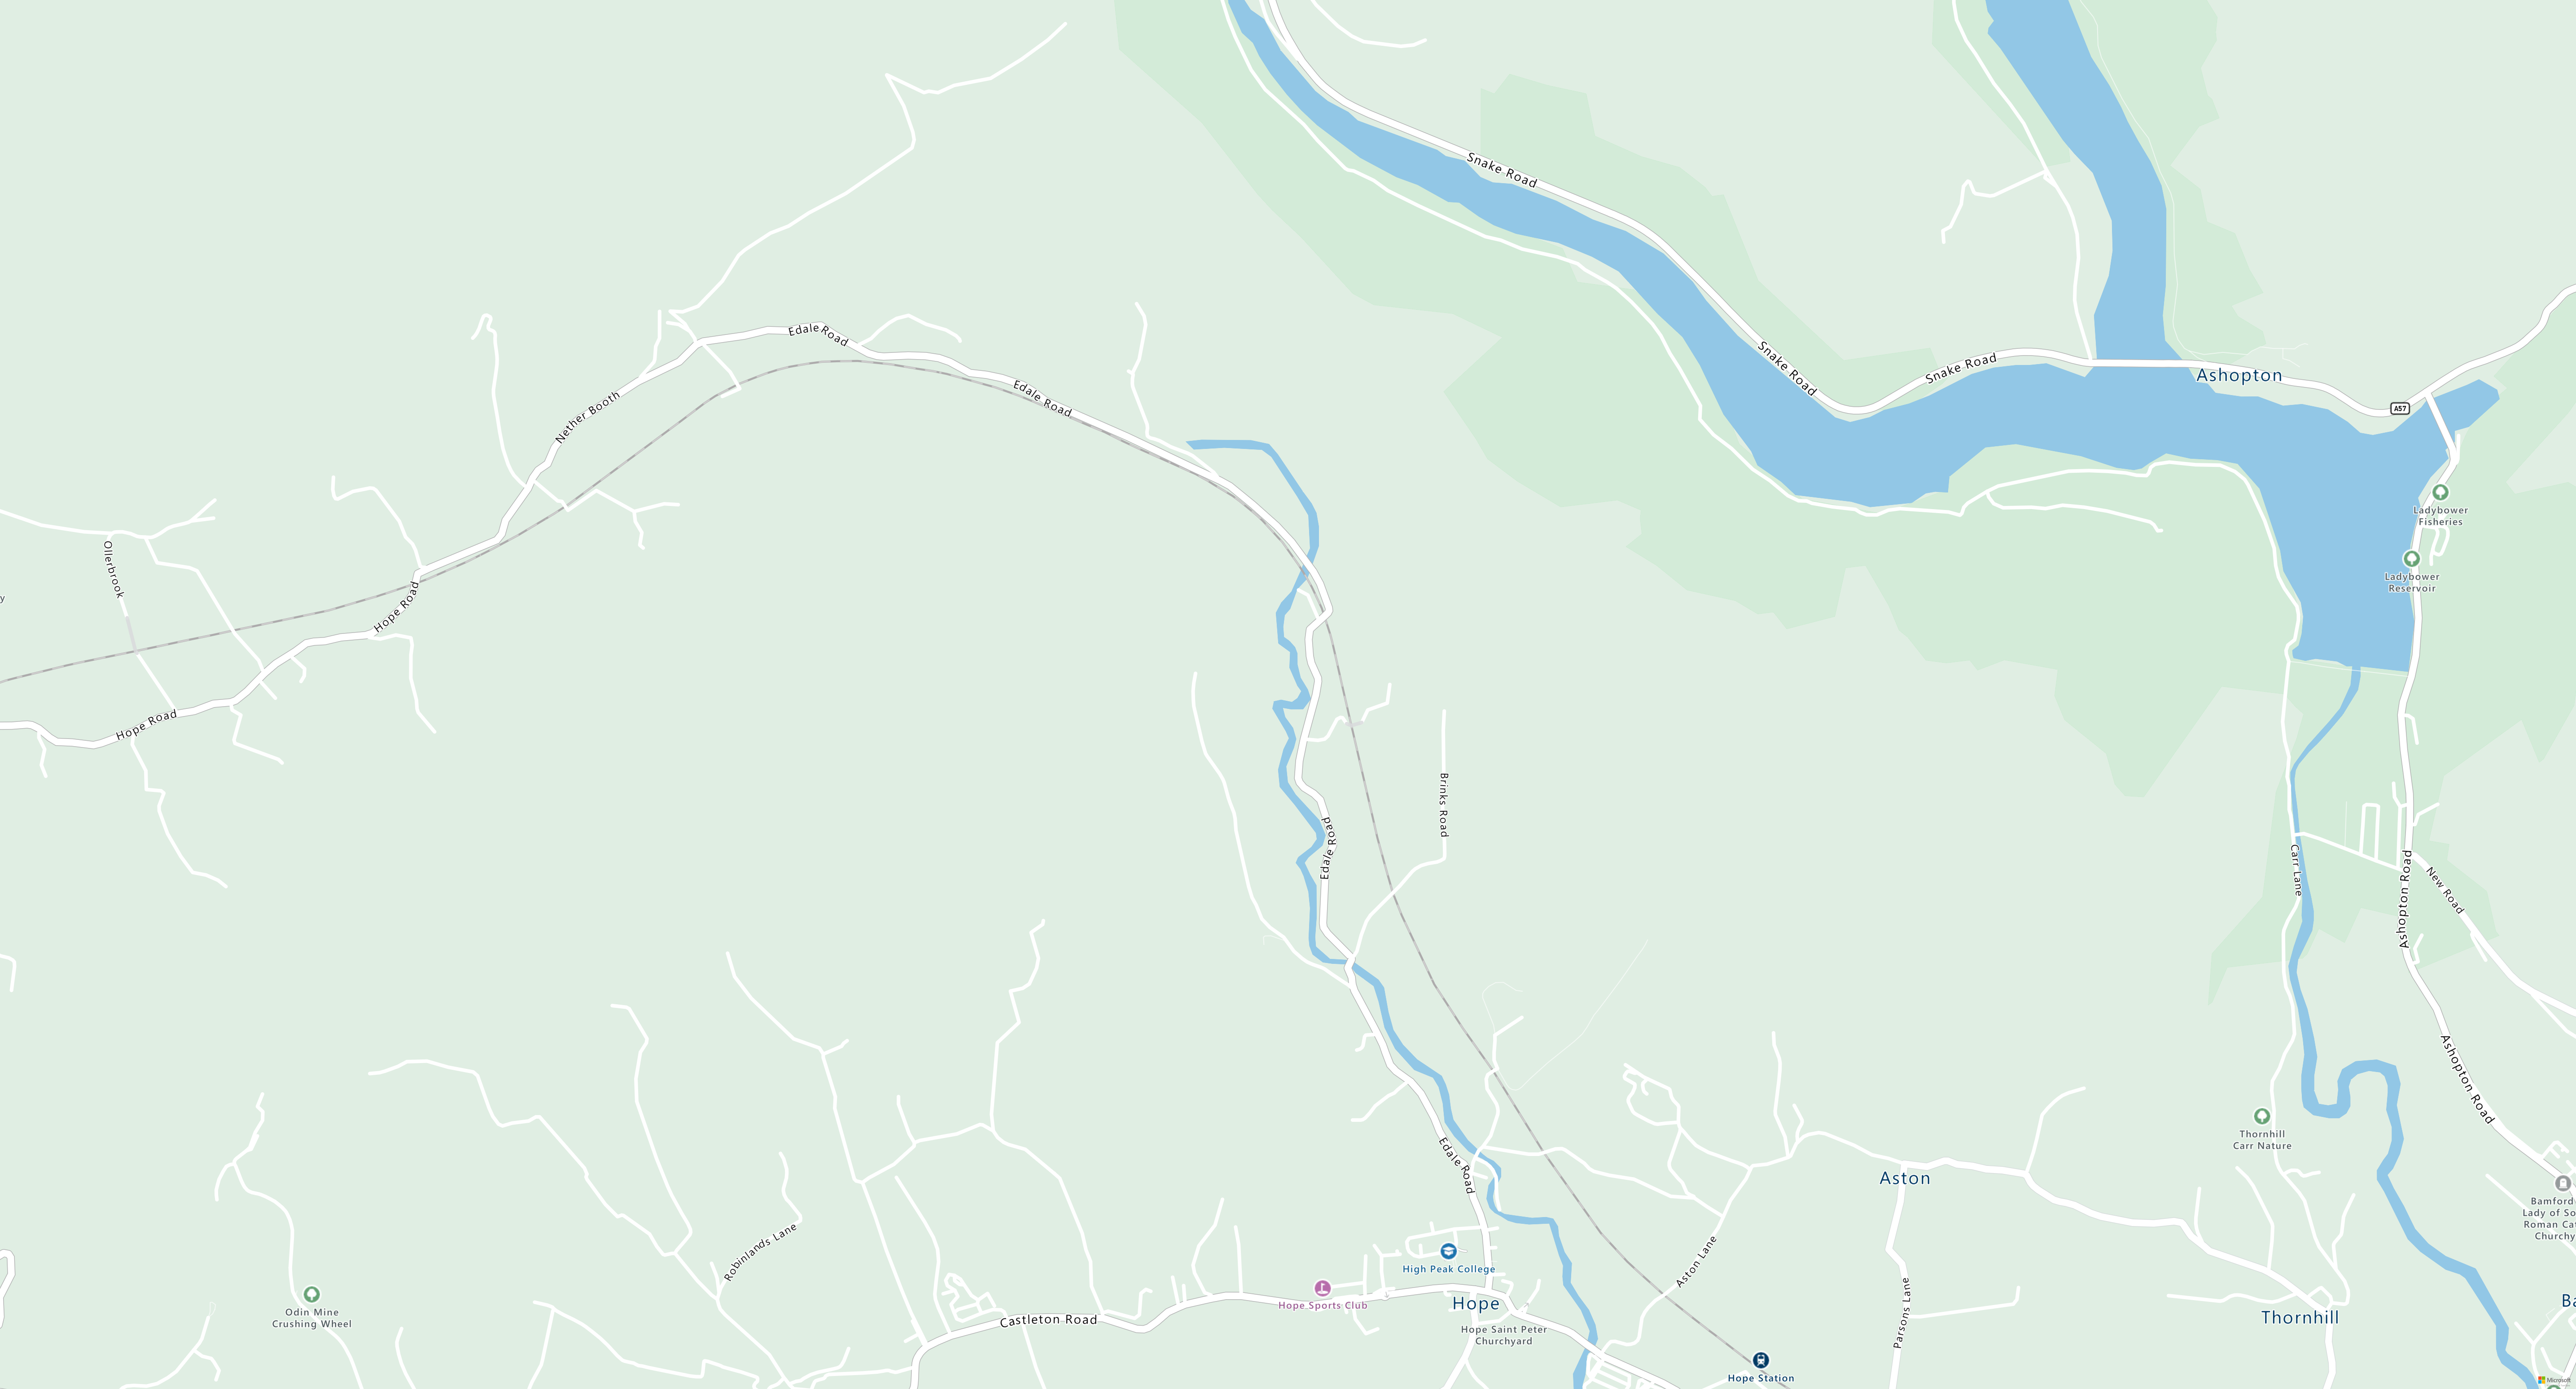

In [0]:
from IPython.display import Image, display

bounding_box = '-1.8136975,53.34539,-1.6905249,53.38501'
AzureMapsAPIKey = dbutils.secrets.get(scope = "allpay-dwh01-scope", key = "AzureMapsAPI-Key")
url = "https://atlas.microsoft.com/map/static/png"

# url = "https://dev.virtualearth.net/REST/v1/Imagery/Map/imagerySet?pushpin=53.369583,-1.6978767;;St&mapLAyer=OrdnanceSurvey&format=png&mapMetadata=0&key=" + BingMapsAPIKey

# https://dev.virtualearth.net/REST/v1/Imagery/Map/imagerySet?pushpin={pushpin_1}&pushpin={pushpin_2}&pushpin={pushpin_n}&mapLayer={mapLayer}&format={format}&mapMetadata={mapMetadata}&key={BingMapsKey}

map_params = {
    'api-version': '1.0',
    'layer': 'basic',
    'tilesetid': 'microsoft.base.road',
    'style': 'main',
    'zoom': 15,
    'bbox':  bounding_box,  # Replace with your desired coordinates
    'subscription-key': AzureMapsAPIKey
}

response = requests.get(url, params=map_params)

display(Image(response.content))

